In [1]:
import pandas as pd
import os
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Input Data
#### real - index: date, columns: real price of each ticker
#### pred - index: date, columns: pred price of each ticker

In [2]:
real = pd.DataFrame()
pred = pd.DataFrame()

for file_name in glob.glob('eod/' + '*.csv'):
    ticker = file_name.split('\\')[1].split('.')[0]
    x = pd.read_csv(file_name, usecols=['Date', 'Adj_Close'])
    x['Date'] = pd.to_datetime(x['Date'])
    x = x[(x['Date'] >= '2021-01-01') & (x['Date'] <= '2021-04-01')]
    x = x.set_index('Date')
    x = x.rename(columns={"Adj_Close": ticker})
    x2 = x.copy()
    x2[ticker] = x2[ticker] - 1
    real = pd.concat([real, x], axis=1)
    pred = pd.concat([pred, x2], axis=1)
real.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,129.216308,485.34,145.367323,168.098951,296.84,80.791184,526.46,156.81,86.714661,92.30,...,729.77,161.227472,202.538034,213.58,229.43,41.008109,228.08,65.174694,142.43,359.98
2021-01-05,130.813913,485.69,147.965657,167.631346,301.70,80.682194,543.65,157.36,89.439779,92.77,...,735.11,162.410191,201.629568,206.50,228.58,40.770381,225.36,64.544339,144.23,360.83
2021-01-06,126.410514,466.31,148.632662,167.044353,302.87,81.326225,540.39,157.76,90.667579,90.33,...,755.98,163.215235,199.722788,199.51,226.65,42.622680,220.00,65.973805,141.22,344.41
2021-01-07,130.724048,477.74,154.914457,167.989512,315.20,79.156337,558.36,155.75,94.390910,95.16,...,816.04,166.912474,200.631254,200.00,232.90,44.831571,226.21,64.683315,149.71,342.50
2021-01-08,131.852356,485.10,156.039407,170.178300,319.85,78.452857,570.53,157.35,95.389121,94.58,...,880.02,170.112773,200.561372,202.44,237.00,44.782044,227.65,65.278925,147.99,349.61


In [3]:
# global parameters
short_tol = -0.01
long_num = 30
balance = 100000.0
pct = 0.8

pred_r = pred.pct_change()
total_days = real.shape[0] - 1

In [4]:
def DivideLongShort(total, pct):
    long_budget = total * pct
    short_margin = total - long_budget
    return long_budget, short_margin

def OrderBook(budget, candidates, costs, long=True):
    orders = {ticker:0 for ticker in candidates}
    order_cost = 0
    ticker_budget = float(budget)/len(candidates)
    
    for i in range(len(candidates)):
        ticker = candidates[i]
        cost = costs[i]
        if long:
            orders[ticker] = int(ticker_budget/cost)
        else:
            orders[ticker] = int(ticker_budget/cost) * -1
        order_cost += orders[ticker] * cost
    
    return orders, order_cost

def UpdateBalance(prev_balance, long_orders, long_cost, short_orders, short_cost, real_prices):
    cur_balance = prev_balance - long_cost - short_cost
    for ticker in long_orders:
        cur_balance += long_orders[ticker] * real_prices[ticker]
    for ticker in short_orders:
        cur_balance += short_orders[ticker] * real_prices[ticker]
    return cur_balance

def DailyTrade(beg_balance, day):
    
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

    short_tickers = daily_data[daily_data['pred_r'] <= short_tol]['ticker'].tolist()
    short_costs = daily_data[daily_data['pred_r'] <= short_tol]['cost'].tolist()
    long_tickers = daily_data.tail(long_num)['ticker'].tolist()
    long_costs = daily_data.tail(long_num)['cost'].tolist()

    long_budget, short_margin = DivideLongShort(beg_balance, pct)
    long_orders, long_order_cost = OrderBook(long_budget, long_tickers, long_costs)
    short_orders, short_order_cost = OrderBook(short_margin, short_tickers, short_costs, False)
    real_prices = real.iloc[day + 1]

    cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, \
                                short_orders, short_order_cost, real_prices)
    
    return cur_balance

def DailyBenchmark(beg_balance, day):
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

    long_tickers = daily_data['ticker'].tolist()
    long_costs = daily_data['cost'].tolist()
    long_orders, long_order_cost = OrderBook(beg_balance, long_tickers, long_costs)
    real_prices = real.iloc[day + 1]

    cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, {}, 0, real_prices)
    
    return cur_balance

In [5]:
tradebal = copy.copy(balance)
bmbal = copy.copy(balance)
benchmark = []
my_portfolio = []

for day in range(total_days):
    tradebal = DailyTrade(tradebal, day)
    my_portfolio.append(tradebal)
    bmbal = DailyBenchmark(bmbal, day)
    benchmark.append(bmbal)

print('benchmark final: ', bmbal)
print('my portfolio final: ', tradebal)

benchmark final:  106125.70082160398
my portfolio final:  401614.96970463585


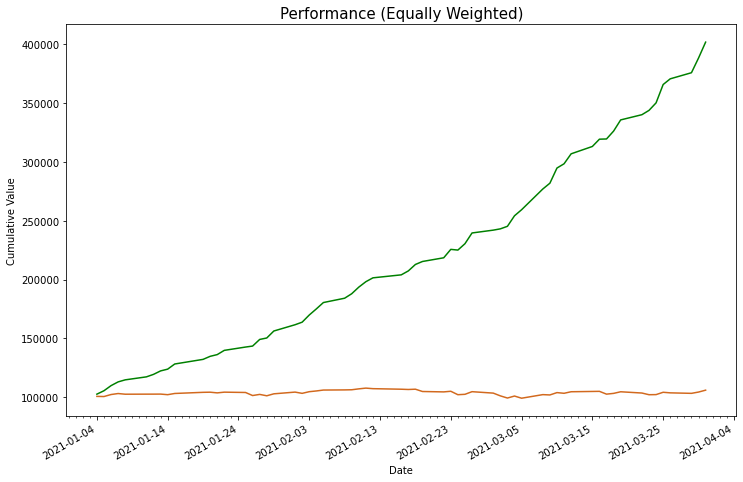

In [6]:
x = list(real.index)[:-1]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)  
ax.plot(x, benchmark, '-', color="chocolate", label='Benchmark')
ax.plot(x, my_portfolio, '-', color="green", label='My Potfolio')

# set xticks
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)
fig.autofmt_xdate()

plt.title("Performance (Equally Weighted)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Cumulative Value")

plt.show()